<a href="https://colab.research.google.com/github/sudip2k17/TextPreprocessingWithSpacy/blob/main/SequentialSentenceClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective:**



1.   Build Deep learning Model for Sequential Sentence Classification, for Converting “Harder to Read” text into “Easier to Read ” text.
2.   Approach:Create many to one model

3. Use following models

  A. Naïve Bayes with TF-IDF encoder (baseline)

  B. Conv1D with token embedding

  C. Pertained Feature Extractor

  D. Conv1D with character embedding





# **Dataset details :**
PubMed 20k RCT is dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 20,000 abstracts of randomized controlled trials. Each sentence of each abstract is labelled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification i.e., classification of short texts that appear in sequences. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [11]:
#storing the PubMed_20k_RCT dataset in reference variable for future use
datafile_directory = "dataset/"

In [12]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# TextVectorization is now in keras.layers.preprocessing
from tensorflow.keras.layers import TextVectorization
import random

In [13]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

train.txt -This contains list of training set.

dev.txt - This contains the development set (i.e validation set)

test.txt - This file contains the test set

In [14]:
#Loading the data
train_data = get_raw_data(datafile_directory + 'train.txt')
#Viewing first 15 records from training dataset file
train_data[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [15]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'):
            abstract_id = int(line.replace('###', '').replace('\n', ''))
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end
            abstract_data_split = abstract_data.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")


                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines
                line_data["target"] = target_text_split[0] # get target label

                abstract_samples.append(line_data)

        else:
            abstract_data += line

    return abstract_samples

In [16]:
#Preprocessing data in train,test and validation sets
train_set_samples = preprocess_raw_data(datafile_directory + "train.txt")
validation_set_samples = preprocess_raw_data(datafile_directory + "dev.txt")
test_set_samples = preprocess_raw_data(datafile_directory + "test.txt")


In [17]:
train_count = len(train_set_samples)
val_count = len(validation_set_samples)
test_count = len(test_set_samples)
print(f'train set samples count:\t{train_count}')
print(f'validation set samples count:\t{val_count}')
print(f'test set samples count:\t\t{test_count}')

train set samples count:	180040
validation set samples count:	30212
test set samples count:		30135


In [18]:
train_set_samples[:20]

[{'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'target': 'OBJECTIVE'},
 {'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'target': 'METHODS'},
 {'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,
  'target': 'METHODS'},
 {'abstract_text': 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
  'line_number': 3,
  'total_lines': 12,
  'target': 'METHODS'},
 {'abstract_text': 'Secondary outcome measu

In [19]:
#converting train,test,validation samples into dataframes
train_df = pd.DataFrame(train_set_samples)
val_df = pd.DataFrame(validation_set_samples)
test_df = pd.DataFrame(test_set_samples)
train_df.head(20)

,abstract_text,line_number,total_lines,target
0,To investigate the efficacy of 6 weeks of dail...,0,12,OBJECTIVE
1,A total of 125 patients with primary knee OA w...,1,12,METHODS
2,Outcome measures included pain reduction and i...,2,12,METHODS
3,Pain was assessed using the visual analog pain...,3,12,METHODS
4,Secondary outcome measures included the Wester...,4,12,METHODS
5,"Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...",5,12,METHODS
6,There was a clinically relevant reduction in t...,6,12,RESULTS
7,The mean difference between treatment arms ( 9...,7,12,RESULTS
8,"Further , there was a clinically relevant redu...",8,12,RESULTS
9,These differences remained significant at 12 w...,9,12,RESULTS


In [20]:
# Check training data distribution
train_df["target"].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<ipython-input-21-0538bc416193>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  train_bar_plot = sns.barplot(x=train_dist.values,
<ipython-input-21-0538bc416193>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  val_bar_plot = sns.barplot(x=val_dist.values,
<ipython-input-21-0538bc416193>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  test_bar_plot = sns.barplot(x=test_dist.values,


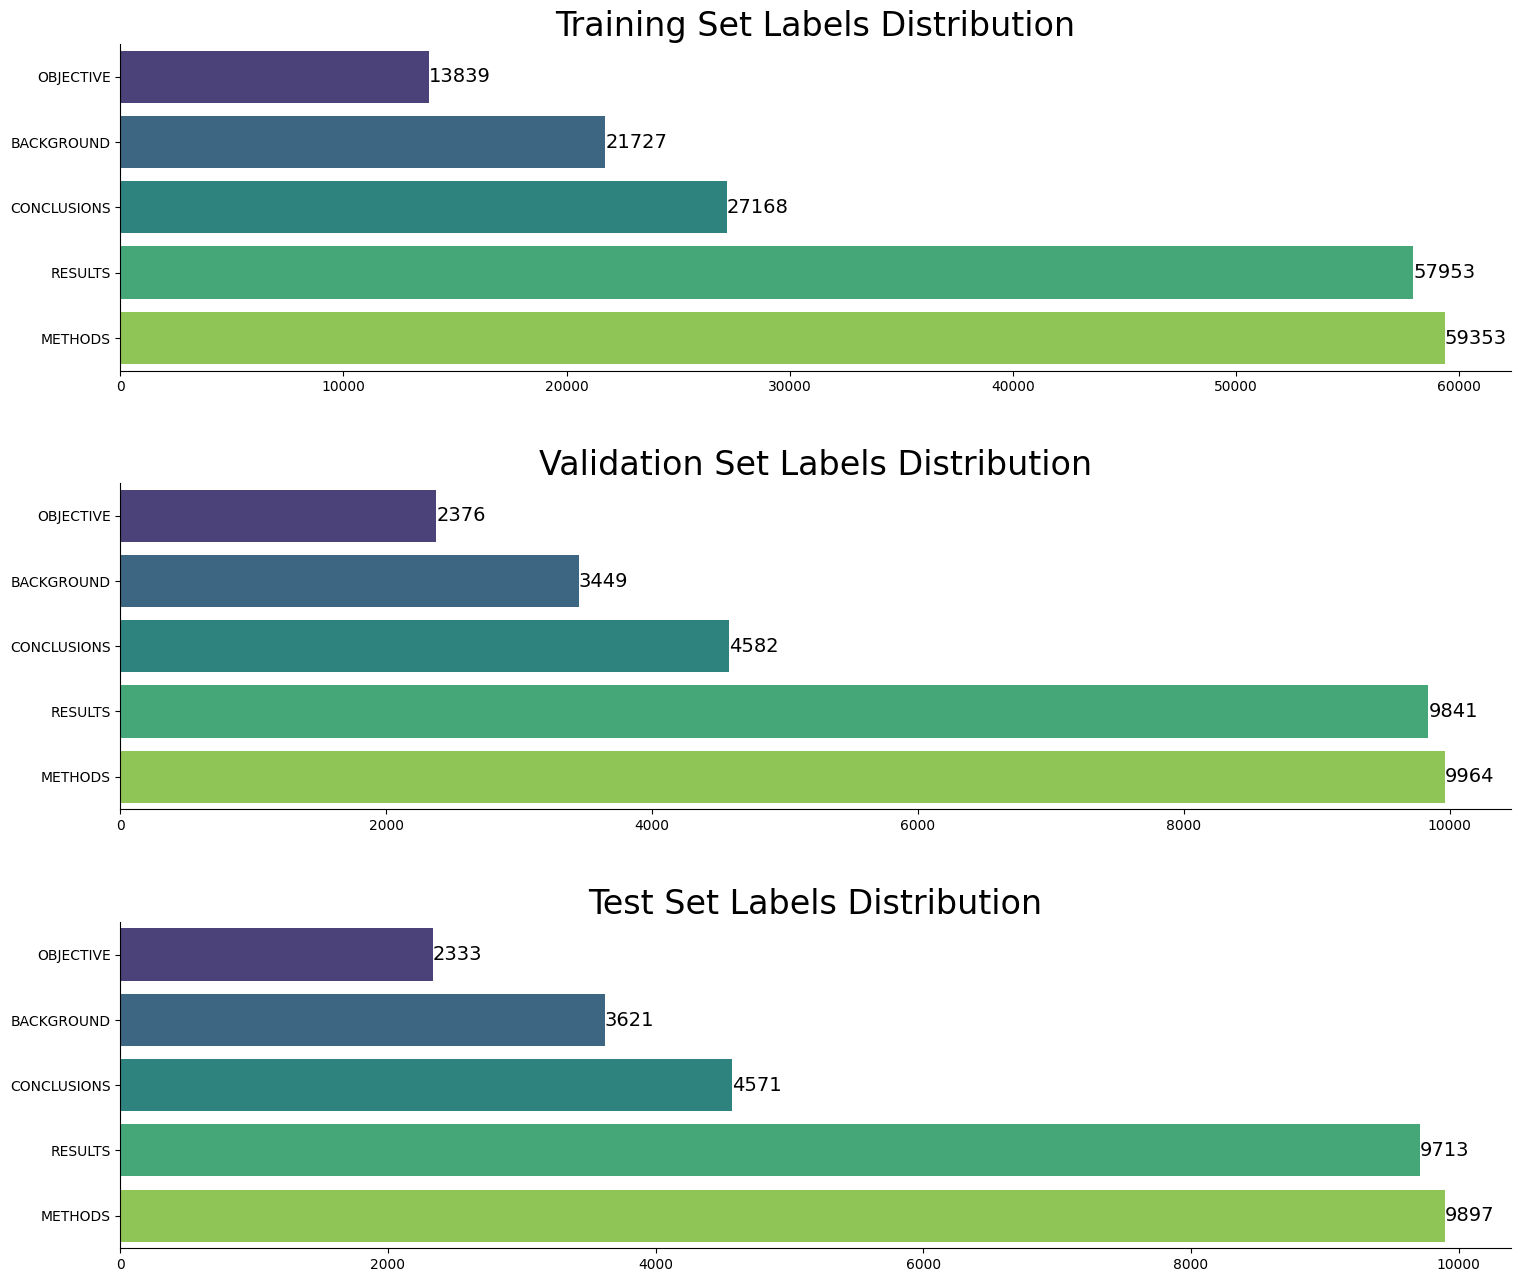

In [21]:
# Create subplots
fig, (ax_train, ax_val, ax_test) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();

# Plot Training Set Labels Distribution
ax_train.set_title('Training Set Labels Distribution', fontsize=24)
train_dist = train_df['target'].value_counts().sort_values()
train_bar_plot = sns.barplot(x=train_dist.values,
                            y=list(train_dist.keys()),
                            orient="h", palette=sns.color_palette("viridis", 5),
                            ax=ax_train);

for container in train_bar_plot.containers:
    train_bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Validation Set Labels Distribution
ax_val.set_title('Validation Set Labels Distribution', fontsize=24)
val_dist = val_df['target'].value_counts().sort_values()
val_bar_plot = sns.barplot(x=val_dist.values,
                           y=list(val_dist.keys()),
                           orient="h", palette=sns.color_palette("viridis", 5),
                           ax=ax_val);

for container in val_bar_plot.containers:
    val_bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Test Set Labels Distribution
ax_test.set_title('Test Set Labels Distribution', fontsize=24)
test_dist = test_df['target'].value_counts().sort_values()
test_bar_plot = sns.barplot(x=test_dist.values,
                            y=list(test_dist.keys()),
                            orient="h", palette=sns.color_palette("viridis", 5),
                            ax=ax_test);

for container in test_bar_plot.containers:
    test_bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.show()

<Axes: ylabel='Frequency'>

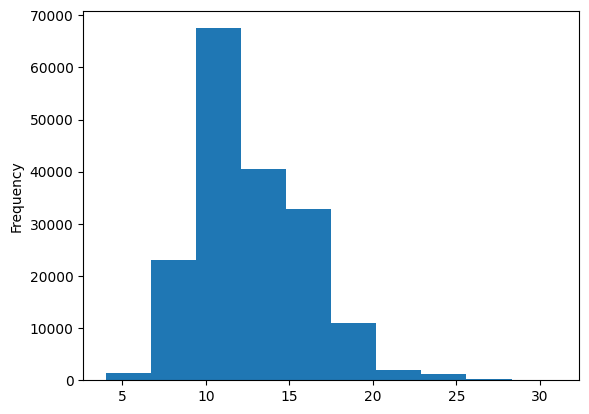

In [22]:
train_df.total_lines.plot(kind= "hist")

In [23]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [24]:
train_sentences[:15]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .',
 'Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was

In [26]:
from sklearn.preprocessing import OneHotEncoder

# Remove the sparse argument, set handle_unknown='ignore' to ignore unseen labels during transform
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [27]:
train_df["target"][0]

'OBJECTIVE'

In [28]:
#Check one hot encoded training label
train_labels_one_hot

<180040x5 sparse matrix of type '<class 'numpy.float64'>'
	with 180040 stored elements in Compressed Sparse Row format>

In [29]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [30]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [31]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [32]:
print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


# **Model 0: Baseline (Naïve Bayes with TF-IDF encoder)**

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a SKlearn pipeline using TF-IDF  and Multinomial Naive bayes algorithm
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

In [34]:
#fitting on train dataset
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [35]:
# Perform evaluation on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7317291142592347

In [36]:
val_predictions = model_0.predict(val_sentences)
test_predictions = model_0.predict(test_sentences)

In [37]:
val_predictions

array([0, 1, 3, ..., 4, 4, 1])

In [38]:
test_predictions

array([2, 2, 2, ..., 4, 4, 4])

In [39]:
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

#Performance metrics summary
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.45      0.53      3449
 CONCLUSIONS       0.63      0.62      0.63      4582
     METHODS       0.72      0.89      0.80      9964
   OBJECTIVE       0.79      0.11      0.19      2376
     RESULTS       0.80      0.87      0.83      9841

    accuracy                           0.73     30212
   macro avg       0.72      0.59      0.60     30212
weighted avg       0.73      0.73      0.71     30212



In [40]:
def generate_performance_scores(y_true, y_pred):

    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)

    performance_dict = {
        'accuracy': model_accuracy,
        'precision': model_precision,
        'recall': model_recall,
        'f1': model_f1
    }

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('=============================================')

    return performance_dict

### **Model_0 Results**

In [41]:
model_0_results= generate_performance_scores(val_labels_encoded, val_predictions)


Performance Metrics:

accuracy_score:		0.73173

_____________________________________________
precision_score:	0.73152

_____________________________________________
recall_score:		0.73173

_____________________________________________
f1_score:		0.70581



# **Preparing data in format suitable for deep learning models**
Vectorization and embedding layers needs to be created so data is in suitable format for Deep learning model

The vectorization layer is going to be used to convert text to numbers and the embedding layer is going to be used to capture the relationships between those numbers.

In [42]:
#The below analysis is being done to know the average,max and min length of sentences in order to ensure when tensorflow model is created the batch size of tensors can be decided so that all batches can have equal size tensors
# Create a list to store the lengths of sentences in the training set
sentence_lengths = []

# Iterate over each sentence in the training set
for sentence in train_sentences:
    # Split the sentence into words and calculate the length
    words_in_sentence = sentence.split()
    length_of_sentence = len(words_in_sentence)

    # Append the length of the sentence to the list
    sentence_lengths.append(length_of_sentence)

# Calculate the average sentence length using NumPy
average_sentence_length = np.mean(sentence_lengths)

# Print the average sentence length
print("Average Sentence Length:", average_sentence_length)

#Min Sentence length
print(min(sentence_lengths))

#Max Sentence length
print(max(sentence_lengths))

Average Sentence Length: 26.338435903132638
1
296


(array([1.6499e+04, 5.6664e+04, 5.2682e+04, 2.9051e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

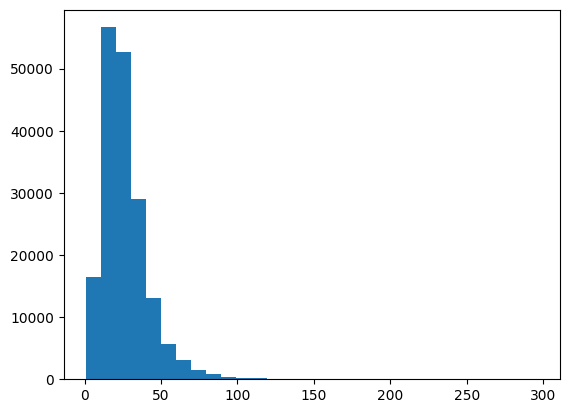

In [43]:
import matplotlib.pyplot as plt
plt.hist(sentence_lengths,bins=30) # Getting most occurence sequence length from sequence distribution

The majority of sentences are between 0 to 55 tokens as per above histogram

In [44]:
np.percentile(sentence_lengths,95)   #checking the percentile distribution for sentence token,95% of sentences have token size of 55 or less


55.0

# **Creation of text vectorizer layer**

In [45]:
max_tokens = 68000  # value 68K taken as reference from table 3.2 of PubMed200K RCT resarch paper https://arxiv.org/pdf/1710.06071.pdf

In [46]:
#creating text vectorizer
#max token- Maximum size of the vocabulary
#output_sequence_length - o/p length of resulting vector sequences
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=55)

In [47]:
text_vectorizer.adapt(train_sentences)

In [48]:
#Validating random sentences from text vectorizer
import random
target_sentence  = random.choice(train_sentences)
print(f"Target Text:\n{target_sentence}")
print(f"\nTarget Text length: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Target Text:
Motivation for retention was related to the desire to serve their communities as well as humanitarian and religious reasons .

Target Text length: 20

Vectorized text:
[[ 2074    11  1201    10   354     6     2  4803     6  3841   127  2799
     25   232    25 35202     3 22257  2511     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [49]:
# Getting current vocabulary and checking vocabulary length
pubmedrct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"total vocabulary words : {len(pubmedrct_20k_vocab)}")

total vocabulary words : 68000


# **Create text embedding**

In [50]:
#Creating embedding layer
#input_dim - vocabulary size
#output_dim- embedding output dimension

token_embed = layers.Embedding(input_dim=len(pubmedrct_20k_vocab),
                               output_dim= 128,
                               mask_zero=True # allows model to ignore padding tokens during training
                               )

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
Motivation for retention was related to the desire to serve their communities as well as humanitarian and religious reasons .

Sentence after vectorization:
[[ 2074    11  1201    10   354     6     2  4803     6  3841   127  2799
     25   232    25 35202     3 22257  2511     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02978295 -0.04329395  0.02983772 ...  0.04223359 -0.035043
    0.03510759]
  [ 0.01570633 -0.00631794 -0.02560896 ... -0.01218269 -0.00662752
    0.04079911]
  [ 0.0155833  -0.01712946 -0.026297   ... -0.03160191 -0.020399
   -0.01006296]
  ...
  [ 0.01714772 -0.04848393 -0.03509215 ... -0.03068628 -0.01918509
   -0.03263853]
  [ 0.01714772 -0.04848393 -0.03509215 ... -0.03068628 -0.01918509
   -0.03263853]
  [ 0.01714772 -0.04848393

In [53]:
#Enable faster loading on GPU by using tf.data prefetch() and batch() methods
# Create and preprocess training dataset
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_sentences, train_labels_one_hot.toarray())) # Convert to dense NumPy array
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Create and preprocess validation dataset
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_sentences, val_labels_one_hot.toarray())) # Convert to dense NumPy array
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Create and preprocess test dataset
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_sentences, test_labels_one_hot.toarray())) # Convert to dense NumPy array
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Check training dataset
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# **Model 1: Conv1D with token embedding**

Model Structure

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [54]:
# Define the input layer for text data
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Apply the text vectorization layer to convert text to numerical sequences
text_vector = text_vectorizer(inputs)

# Embed the numerical sequences using token embeddings
embeddings = token_embed(text_vector)

# Apply a 1D convolutional layer with 64 filters and kernel size of 5
conv1d_output = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(embeddings)

# Global max pooling layer to capture key features
global_max_pooling_output = tf.keras.layers.GlobalMaxPooling1D()(conv1d_output)

# Dropout layer for regularization
dropout_output = tf.keras.layers.Dropout(0.2)(global_max_pooling_output)

# Output layer with softmax activation for multi-class classification
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout_output)

# Create the model
model1 = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [55]:
#compile model
model1.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [56]:
# Display model summary
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 55, 128)             │       8,704,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,745,349 (33.36 MB)

 Trainable params: 8,745,349 (33.36 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
#Fit the model on smaller subset of data (here value is taken as 10%  of training and validation set data as it is more sensible to run smaller experiments and training models on large datasets on GPU takes time)
model1_history =  model1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs = 10,
                             validation_data = valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - accuracy: 0.5384 - loss: 1.1360 - val_accuracy: 0.7796 - val_loss: 0.5988
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.7736 - loss: 0.6290 - val_accuracy: 0.8035 - val_loss: 0.5454
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7888 - loss: 0.5770 - val_accuracy: 0.8085 - val_loss: 0.5234
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 57s 102ms/step - accuracy: 0.7950 - loss: 0.5604 - val_accuracy: 0.8078 - val_loss: 0.5207
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 60s 107ms/step - accuracy: 0.7956 - loss: 0.5601 - val_accuracy: 0.8132 - val_loss: 0.5083
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 61s 108ms/step - accuracy: 0.8033 - loss: 0.5514 - val_accuracy: 0.8238 - val_loss: 0.5038
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.8100 - loss: 0.5196 - val_accuracy: 0.8291 - val_loss: 0.4868
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.8135 - loss: 0.

In [58]:
# Evaluating on entire validation dataset
model1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8294 - loss: 0.4675


[0.4707532823085785, 0.8311266899108887]

In [59]:
# Make predictions
model1_prediction_probablities = model1.predict(valid_dataset)
model1_prediction_probablities

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


array([[4.0953663e-01, 1.6311796e-01, 3.3855267e-02, 3.4514105e-01,
        4.8349060e-02],
       [4.0514398e-01, 4.0825525e-01, 2.0183683e-03, 1.6708942e-01,
        1.7492944e-02],
       [1.5185764e-01, 9.1660913e-04, 1.8315266e-04, 8.4702629e-01,
        1.6216425e-05],
       ...,
       [4.3150427e-05, 5.3231424e-04, 7.6470030e-03, 3.5272336e-05,
        9.9174225e-01],
       [1.2360653e-02, 4.8593110e-01, 2.6827525e-02, 6.5563512e-03,
        4.6832445e-01],
       [2.6175909e-02, 9.6225125e-01, 2.4220319e-03, 1.7191141e-03,
        7.4316813e-03]], dtype=float32)

In [60]:
# Convert prediction probablities to classes
model_1_predictions = tf.argmax(model1_prediction_probablities, axis=1)
model_1_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

**Model1 Results**

In [61]:
model1_results= generate_performance_scores(val_labels_encoded, model_1_predictions)


Performance Metrics:

accuracy_score:		0.83113

_____________________________________________
precision_score:	0.82869

_____________________________________________
recall_score:		0.83113

_____________________________________________
f1_score:		0.82861



# **Model 2: Feature extraction with pretrained token embedding**

Pretrained model used: pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

Reasons for using the above model:

Low inference time
Computationally inexpensive to use
Model structure:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

In [62]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [63]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [64]:
# Test out the embedding on a random sentence
# Select a random sentence from the training set
random_training_sentence = random.choice(train_sentences)

# Display the random training sentence
print(f"Random training sentence:\n{random_training_sentence}\n")

# Use the TensorFlow Hub embedding layer to embed the random sentence
embedded_sentence = encoder([random_training_sentence])

# Display the embedded sentence (showing the first 20 elements, truncated if necessary)
print(f"Sentence after embedding:\n{embedded_sentence[0][:20]} (truncated output)...\n")

# Display the length of the embedded sentence
print(f"Length of sentence embedding:\n{len(embedded_sentence[0])}")

Random training sentence:
In patients with persistent atrial fibrillation ( AF ) , ablation of complex fractionated atrial electrograms ( CFAEs ) after PVI results in improved outcomes .

Sentence after embedding:
[-0.05646534  0.04570793 -0.01834013 -0.03223228 -0.0242869  -0.01699165
  0.02847155 -0.05534559  0.00115933  0.06441926  0.08317966 -0.05145121
  0.06491235  0.0634945   0.03249245 -0.00594434 -0.08432204 -0.01551982
 -0.02573283  0.07388622] (truncated output)...

Length of sentence embedding:
512


In [66]:
# Define a feature extractor model using TF Hub layer
input_layer = tf.keras.layers.Input(shape=[], dtype=tf.string)

# Create a custom layer to wrap the TensorFlow Hub layer
class USE_embedding_layer(tf.keras.layers.Layer):
    def __init__(self, encoder):
        super(USE_embedding_layer, self).__init__()
        self.encoder = encoder

    def call(self, inputs):
        return self.encoder(inputs)

# Tokenize text and create embedding using the custom layer
embedding_layer = USE_embedding_layer(encoder)(input_layer)

# Add a fully connected layer on top of the embedding
dense_layer = tf.keras.layers.Dense(128, activation="relu")(embedding_layer)

# Create the output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax")(dense_layer)

# Create the model
model2_feature_extractor_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [67]:
# Compile the model
model2_feature_extractor_model.compile(loss="categorical_crossentropy",
                                optimizer=tf.keras.optimizers.Adam(),
                                metrics=["accuracy"])

In [68]:
# Display model summary
model2_feature_extractor_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ use_embedding_layer                  │ (None, 512)                 │               0 │
│ (USE_embedding_layer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#Fit the model on smaller subset of data (here value is taken as 10%  of training and validation set data as it is more sensible to run smaller experiments and training models on large datasets on GPU takes time)
model2_feature_extractor_model_history =  model2_feature_extractor_model.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs = 10,
                             validation_data = valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5905 - loss: 1.0744 - val_accuracy: 0.6928 - val_loss: 0.7752
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7138 - loss: 0.7456 - val_accuracy: 0.7124 - val_loss: 0.7325
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7238 - loss: 0.7230 - val_accuracy: 0.7194 - val_loss: 0.7177
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7338 - loss: 0.6977 - val_accuracy: 0.7281 - val_loss: 0.6917
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7325 - loss: 0.6870 - val_accuracy: 0.7297 - val_loss: 0.6713
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7363 - loss: 0.6855 - val_accuracy: 0.7410 - val_loss: 0.6656
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7506 - loss: 0.6533 - val_accuracy: 0.7503 - val_loss: 0.6477
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7520 - loss: 0.6553 - val_accu

In [70]:
# Evaluate on entire validation dataset
model2_feature_extractor_model.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7584 - loss: 0.6321


[0.6332781314849854, 0.7601615190505981]

In [71]:
# Make predictions with feature extraction model
model2_feature_extractor_model_prediction_probablities = model2_feature_extractor_model.predict(valid_dataset)
model2_feature_extractor_model_prediction_probablities

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


array([[4.2150870e-01, 4.6067733e-01, 4.9572677e-04, 1.0767665e-01,
        9.6415840e-03],
       [3.7432411e-01, 5.3760076e-01, 3.9939173e-03, 8.2813673e-02,
        1.2674999e-03],
       [3.7561923e-01, 2.7050985e-02, 6.0743205e-03, 5.8430046e-01,
        6.9550336e-03],
       ...,
       [5.3383131e-04, 4.1558809e-04, 2.1079456e-02, 1.5736170e-04,
        9.7781384e-01],
       [2.5966174e-03, 1.1632027e-02, 2.1257974e-01, 7.9980219e-04,
        7.7239186e-01],
       [6.9240212e-02, 8.4393889e-01, 7.1265988e-02, 1.4541897e-03,
        1.4100708e-02]], dtype=float32)

In [72]:
# Convert the predictions probablities to classes
model2_feature_extractor_model_predictions = tf.argmax(model2_feature_extractor_model_prediction_probablities, axis=1)
model2_feature_extractor_model_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

**Model2 Results**

In [73]:
model2_feature_extractor_model_results= generate_performance_scores(val_labels_encoded, model2_feature_extractor_model_predictions)


Performance Metrics:

accuracy_score:		0.76016

_____________________________________________
precision_score:	0.75502

_____________________________________________
recall_score:		0.76016

_____________________________________________
f1_score:		0.75574



# **Model 3: Conv1D with character embedding**

Approach used:

Split the sequences into characters and perform textvectorization on resulting sequence
Perform embedding on the sequence obtained from step 1
Model structure:

Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

**Creating a character-level tokenizer**

In [74]:
def split_into_characters(text):
    """Split a given text into individual characters and join them with spaces."""
    return " ".join(list(text))

# Test the function with a random training sentence
resulting_characters = split_into_characters(random_training_sentence)
resulting_characters

'I n   p a t i e n t s   w i t h   p e r s i s t e n t   a t r i a l   f i b r i l l a t i o n   (   A F   )   ,   a b l a t i o n   o f   c o m p l e x   f r a c t i o n a t e d   a t r i a l   e l e c t r o g r a m s   (   C F A E s   )   a f t e r   P V I   r e s u l t s   i n   i m p r o v e d   o u t c o m e s   .'

In [75]:
# Split the training, validation, and test sets into character-level data
train_chars = [split_into_characters(sentence) for sentence in train_sentences]
val_chars = [split_into_characters(sentence) for sentence in val_sentences]
test_chars = [split_into_characters(sentence) for sentence in test_sentences]
print(train_chars[1])

A   t o t a l   o f   1 2 5   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   1 : 1   ;   6 3   r e c e i v e d   7 . 5   m g / d a y   o f   p r e d n i s o l o n e   a n d   6 2   r e c e i v e d   p l a c e b o   f o r   6   w e e k s   .


In [76]:
# Calculate the character lengths for each training sentence
char_lengths = [len(sentence) for sentence in train_sentences]

# Calculate the total sum of character lengths
total_char_length = sum(char_lengths)

# Calculate the total number of training sentences
num_train_sentences = len(char_lengths)

# Calculate the average character length
average_char_length = total_char_length / num_train_sentences

# Display the average character length
print("Average Character Length in Training Sentences:", average_char_length)

Average Character Length in Training Sentences: 152.006276383026


(array([8.7270e+03, 3.8115e+04, 5.1735e+04, 3.8852e+04, 2.2025e+04,
        1.1103e+04, 4.9830e+03, 2.2870e+03, 1.0750e+03, 5.2400e+02,
        2.6800e+02, 1.4200e+02, 7.9000e+01, 5.3000e+01, 1.5000e+01,
        2.3000e+01, 6.0000e+00, 6.0000e+00, 8.0000e+00, 5.0000e+00,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   2. ,   50.4,   98.8,  147.2,  195.6,  244. ,  292.4,  340.8,
         389.2,  437.6,  486. ,  534.4,  582.8,  631.2,  679.6,  728. ,
         776.4,  824.8,  873.2,  921.6,  970. , 1018.4, 1066.8, 1115.2,
        1163.6, 1212. , 1260.4, 1308.8, 1357.2, 1405.6, 1454. ]),
 <BarContainer object of 30 artists>)

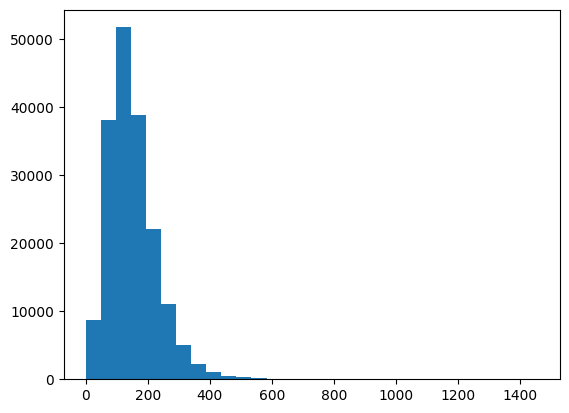

In [77]:
plt.hist(char_lengths,bins =30)   #Checking sequence distribution at character level

The majority of sentences are between 0 to 200 characters long as per above histogram

In [78]:
output_sequence_character_length = int(np.percentile(char_lengths, 95))# Determine character length which covers 95% of sequences

In [79]:
output_sequence_character_length

296

In [80]:
max_tokens= 28 # Total no of characters = total no of characters in alphabet+ space+ OOV(out of vocabulary token)

In [81]:
# Create char-level token vectorizer instance
char_vectorizer = TextVectorization(max_tokens,
                                    output_sequence_length=output_sequence_character_length,
                                    standardize="lower_and_strip_punctuation")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [82]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Total Number of unique characters in vocabulary: {len(char_vocab)}")

Total Number of unique characters in vocabulary: 28


In [83]:
# Validate character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of characters: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized characters:\n{vectorized_chars}")
print(f"\nLength of vectorized characters: {len(vectorized_chars[0])}")

Charified text:
T o   d a t e   ,   s t u d i e s   a s s e s s i n g   t h e   r i s k   o f   p o s t - t r a n s p l a n t   h e p a t o c e l l u l a r   c a r c i n o m a   (   H C C   )   r e c u r r e n c e   h a v e   f o c u s e d   o n   t u m o u r   c h a r a c t e r i s t i c s   .

Length of characters: 120

Vectorized characters:
[[ 3  7 10  5  3  2  9  3 16 10  4  2  9  5  9  9  2  9  9  4  6 18  3 13
   2  8  4  9 27  7 17 14  7  9  3  3  8  5  6  9 14 12  5  6  3 13  2 14
   5  3  7 11  2 12 12 16 12  5  8 11  5  8 11  4  6  7 15  5 13 11 11  8
   2 11 16  8  8  2  6 11  2 13  5 21  2 17  7 11 16  9  2 10  7  6  3 16
  15  7 16  8 11 13  5  8  5 11  3  2  8  4  9  3  4 11  9  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

# **Create a character-level embedding**

In [84]:
#Create character embedding
#input_dim = no of characters in vocabulary(max tokens)
#output dim= referred embedding dimension from Fig 1 of research paper https://arxiv.org/pdf/1612.05251.pdf
char_embed = layers.Embedding(input_dim=max_tokens,
                              output_dim= 25,
                              mask_zero= True)

In [85]:
# Validate character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
T o   d a t e   ,   s t u d i e s   a s s e s s i n g   t h e   r i s k   o f   p o s t - t r a n s p l a n t   h e p a t o c e l l u l a r   c a r c i n o m a   (   H C C   )   r e c u r r e n c e   h a v e   f o c u s e d   o n   t u m o u r   c h a r a c t e r i s t i c s   .

Embedded chars (after vectorization and embedding):
[[[ 0.02904535 -0.04220021 -0.04923427 ...  0.04099709 -0.00309656
    0.04797598]
  [-0.02479016  0.00846076  0.0104203  ... -0.04834871  0.00594983
    0.02091816]
  [ 0.04618258 -0.03924105 -0.04135121 ... -0.01073998 -0.01350888
   -0.03472824]
  ...
  [-0.04853839  0.02382739 -0.04442017 ...  0.02042817  0.03393117
    0.00017621]
  [-0.04853839  0.02382739 -0.04442017 ...  0.02042817  0.03393117
    0.00017621]
  [-0.04853839  0.02382739 -0.04442017 ...  0.02042817  0.03393117
    0.00017621]]]

Character embedding shape: (1, 296, 25)


In [87]:
# Create TensorFlow datasets for character-level training and validation data
train_char_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_chars, train_labels_one_hot.toarray())) # Convert to dense NumPy array
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_char_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_chars, val_labels_one_hot.toarray())) # Convert to dense NumPy array
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_char_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_chars, test_labels_one_hot.toarray())) # Convert to dense NumPy array
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)




#Check training character dataset
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [88]:
# Define the input layer for character-level data
input_layer = tf.keras.layers.Input(shape=(1,), dtype="string")

# Apply the character vectorization layer to convert characters to numerical sequences
char_vectors = char_vectorizer(input_layer)

# Apply the character embedding layer to create dense representations of characters
char_embeddings = char_embed(char_vectors)

# Apply a 1D convolutional layer
conv1d_output = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)

# Apply global max pooling to capture key features from the convolutional layer
global_max_pooling_output = tf.keras.layers.GlobalMaxPooling1D()(conv1d_output)

# Create the output layer with softmax activation for multi-class classification
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(global_max_pooling_output)

# Create the Conv1D character-level model
model3 = tf.keras.Model(inputs=input_layer, outputs=output_layer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [89]:
# Compile the model
model3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [90]:
# Display the model summary
model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 296)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 296, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 296, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Fit the model
model3_history = model3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4332 - loss: 1.3788 - val_accuracy: 0.6260 - val_loss: 0.9646
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6188 - loss: 0.9539 - val_accuracy: 0.6506 - val_loss: 0.8818
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6534 - loss: 0.8673 - val_accuracy: 0.6785 - val_loss: 0.8144
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6727 - loss: 0.8306 - val_accuracy: 0.6882 - val_loss: 0.7911
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6886 - loss: 0.7993 - val_accuracy: 0.7101 - val_loss: 0.7642
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6919 - loss: 0.7912 - val_accuracy: 0.7071 - val_loss: 0.7446
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7010 - loss: 0.7673 - val_accuracy: 0.7128 - val_loss: 0.7375
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7127 - loss: 0.7450 - val_a

In [92]:
# Evaluate model on entire validation dataset
model3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7252 - loss: 0.7111


[0.7135460376739502, 0.7259697914123535]

In [93]:
# Make predictions
model3_prediction_probablities = model3.predict(val_char_dataset)
model3_prediction_probablities

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


array([[0.23056908, 0.4522345 , 0.01541788, 0.29380205, 0.00797646],
       [0.31624395, 0.50662076, 0.00369833, 0.15775375, 0.01568318],
       [0.20907328, 0.12473407, 0.00573537, 0.6562428 , 0.00421452],
       ...,
       [0.00122671, 0.00662934, 0.01562126, 0.00117774, 0.9753449 ],
       [0.01500225, 0.04116349, 0.7304457 , 0.01605817, 0.19733039],
       [0.11983707, 0.8470133 , 0.02003584, 0.00970844, 0.00340536]],
      dtype=float32)

In [94]:
# Convert predictions to classes
model3_predictions = tf.argmax(model3_prediction_probablities, axis=1)
model3_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

**Model_3 Results**

In [95]:
model3_results= generate_performance_scores(val_labels_encoded, model3_predictions)


Performance Metrics:

accuracy_score:		0.72597

_____________________________________________
precision_score:	0.72032

_____________________________________________
recall_score:		0.72597

_____________________________________________
f1_score:		0.72224



# **Comparison of Model Results on Validation set**

In [96]:
# Combine validation model results into a DataFrame
combined_validation_model_results = pd.DataFrame({"Naïve Bayes with TF-IDF encoder baseline": model_0_results,
                                  "Conv1D with token embedding": model1_results,
                                  "pretrained feature extractor": model2_feature_extractor_model_results,
                                  "Conv1D with character embedding": model3_results})
combined_validation_model_results = combined_validation_model_results.transpose()
combined_validation_model_results

,accuracy,precision,recall,f1
Naïve Bayes with TF-IDF encoder baseline,0.73173,0.73152,0.73173,0.70581
Conv1D with token embedding,0.83113,0.82869,0.83113,0.82861
pretrained feature extractor,0.76016,0.75502,0.76016,0.75574
Conv1D with character embedding,0.72597,0.72032,0.72597,0.72224


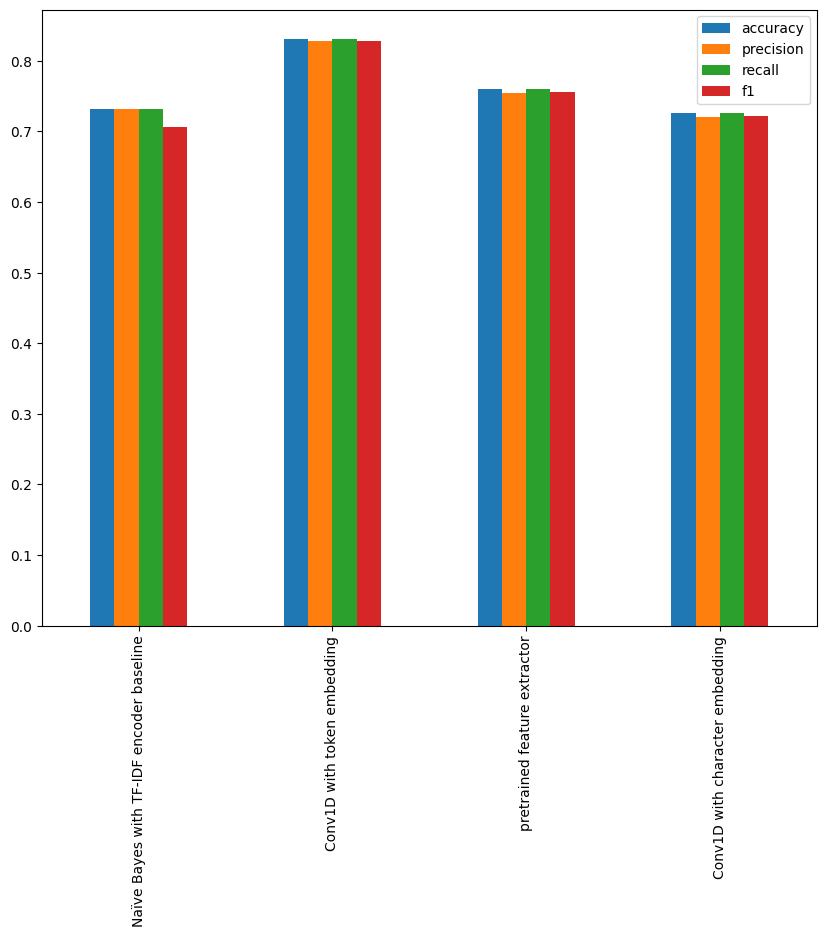

In [97]:
# Plot the combined model results as a bar chart
ax = combined_validation_model_results.plot(kind="bar", figsize=(10, 8))

# Add a legend to the upper right corner
ax.legend(loc="upper right")

# Show the plot
plt.show()

<Axes: >

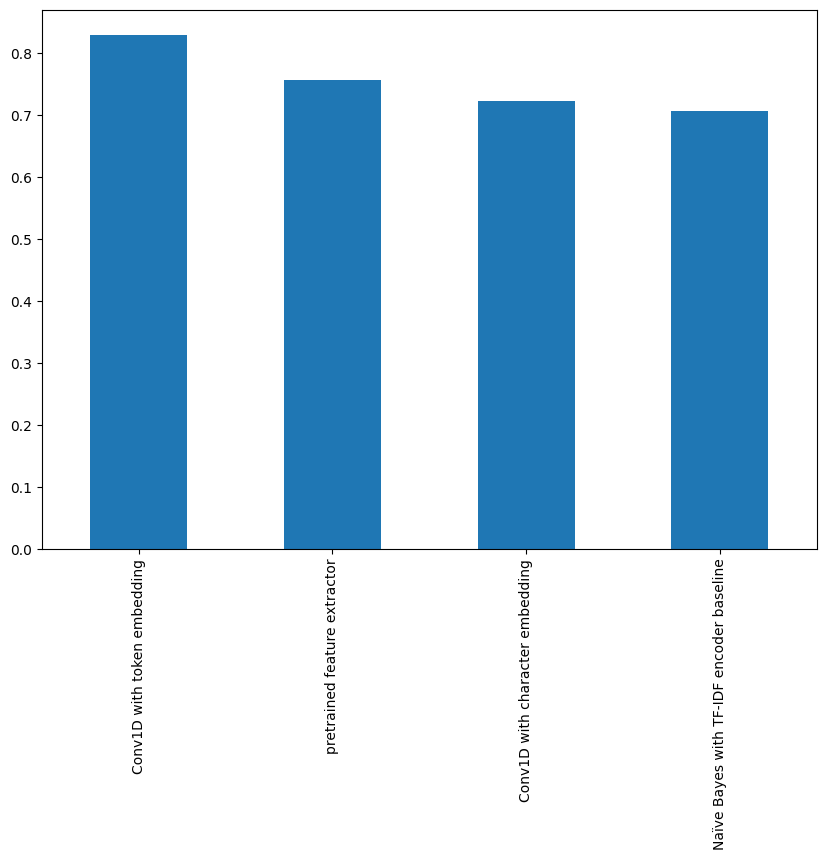

In [98]:
# Sort model results by f1-score
combined_validation_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

**Comparison of Model Results on Test set**

In [99]:
model_1_pred_probs = model1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_2_pred_probs = model2_feature_extractor_model.predict(test_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_3_pred_probs = model3.predict(test_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
942/942 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
942/942 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [100]:
# Generate performance scores on Model0,Model1,Model2,Model3 results for test set
model0_test_results= generate_performance_scores(test_labels_encoded, test_predictions)
model1_test_results= generate_performance_scores(test_labels_encoded, model_1_preds)
model2_test_results= generate_performance_scores(test_labels_encoded, model_2_preds)
model3_test_results= generate_performance_scores(test_labels_encoded, model_3_preds)


Performance Metrics:

accuracy_score:		0.72656

_____________________________________________
precision_score:	0.72184

_____________________________________________
recall_score:		0.72656

_____________________________________________
f1_score:		0.69939


Performance Metrics:

accuracy_score:		0.82323

_____________________________________________
precision_score:	0.81965

_____________________________________________
recall_score:		0.82323

_____________________________________________
f1_score:		0.82029


Performance Metrics:

accuracy_score:		0.75301

_____________________________________________
precision_score:	0.74758

_____________________________________________
recall_score:		0.75301

_____________________________________________
f1_score:		0.7485


Performance Metrics:

accuracy_score:		0.72427

_____________________________________________
precision_score:	0.71939

_____________________________________________
recall_score:		0.72427

_______________________________________

In [101]:
# Combine test model results into a DataFrame
combined_test_model_results = pd.DataFrame({"Naïve Bayes with TF-IDF encoder baseline": model0_test_results,
                                  "Conv1D with token embedding": model1_test_results,
                                  "pretrained feature extractor": model2_test_results,
                                  "Conv1D with character embedding": model3_test_results})
combined_test_model_results = combined_test_model_results.transpose()
combined_test_model_results

,accuracy,precision,recall,f1
Naïve Bayes with TF-IDF encoder baseline,0.72656,0.72184,0.72656,0.69939
Conv1D with token embedding,0.82323,0.81965,0.82323,0.82029
pretrained feature extractor,0.75301,0.74758,0.75301,0.74850
Conv1D with character embedding,0.72427,0.71939,0.72427,0.72062


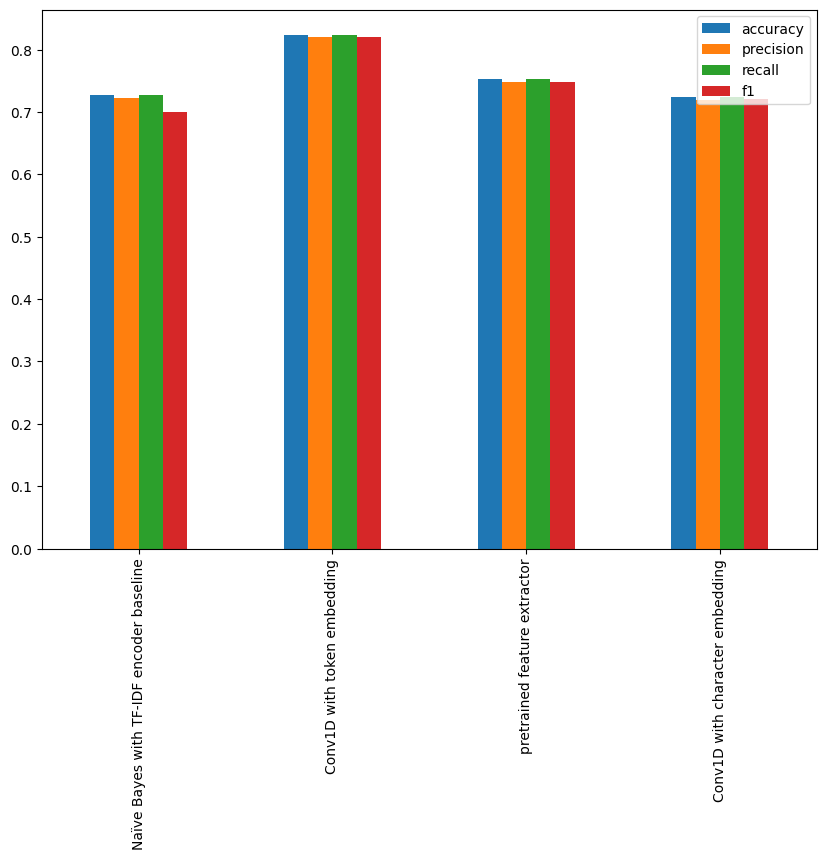

In [102]:
# Plot the combined model results as a bar chart
ax = combined_test_model_results.plot(kind="bar", figsize=(10, 7))

# Add a legend to the upper right corner
ax.legend(loc="upper right")

# Show the plot
plt.show()

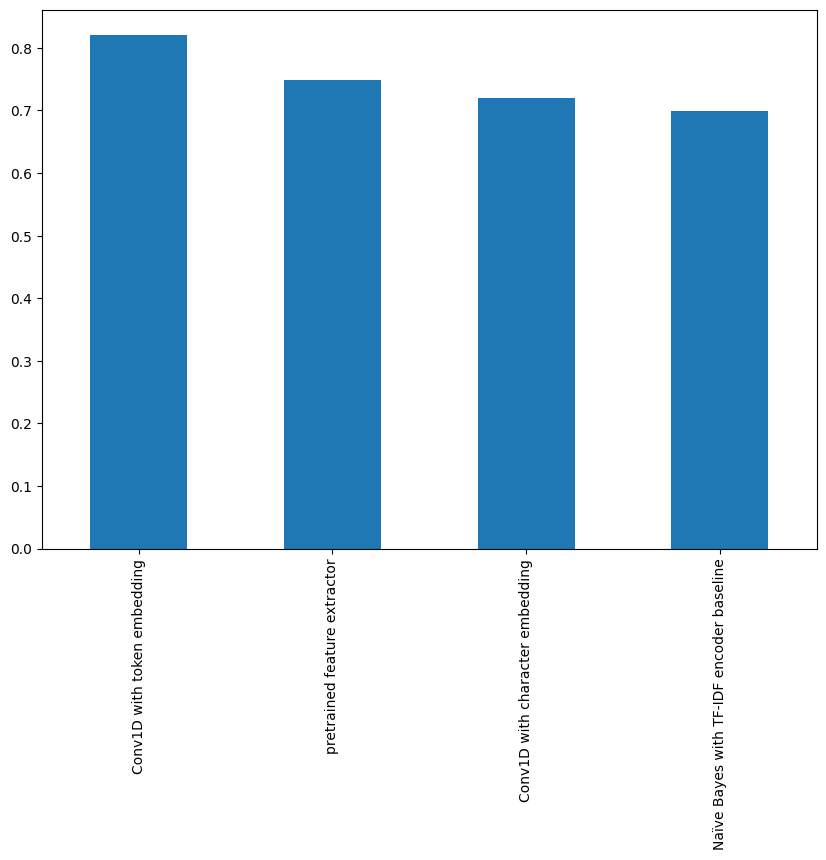

In [103]:
# Sort model results by f1-score
combined_test_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [104]:
print("Classification metrics for Model 1")
print(classification_report(test_labels_encoded, model_1_preds, target_names=class_names))

Classification metrics for Model 1
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.64      0.66      3621
 CONCLUSIONS       0.74      0.76      0.75      4571
     METHODS       0.89      0.92      0.90      9897
   OBJECTIVE       0.71      0.54      0.61      2333
     RESULTS       0.87      0.90      0.88      9713

    accuracy                           0.82     30135
   macro avg       0.78      0.75      0.76     30135
weighted avg       0.82      0.82      0.82     30135



In [105]:
def plot_custom_confusion_matrix(y_true, y_pred, classes='auto', figsize=(12, 12), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create custom confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Blues',  # Change colormap to Blues
        annot_kws={"size": text_size},
        fmt=',',  # Use commas as thousand separators
        linewidths=2, linecolor='gray',  # Change line color to gray
        cbar=False,  # Remove color bar
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Custom Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=22)  # Increase x-axis label font size
    disp.set_ylabel('True Label', fontsize=22)  # Increase y-axis label font size

    # Plot custom confusion matrix
    plt.show()

    return

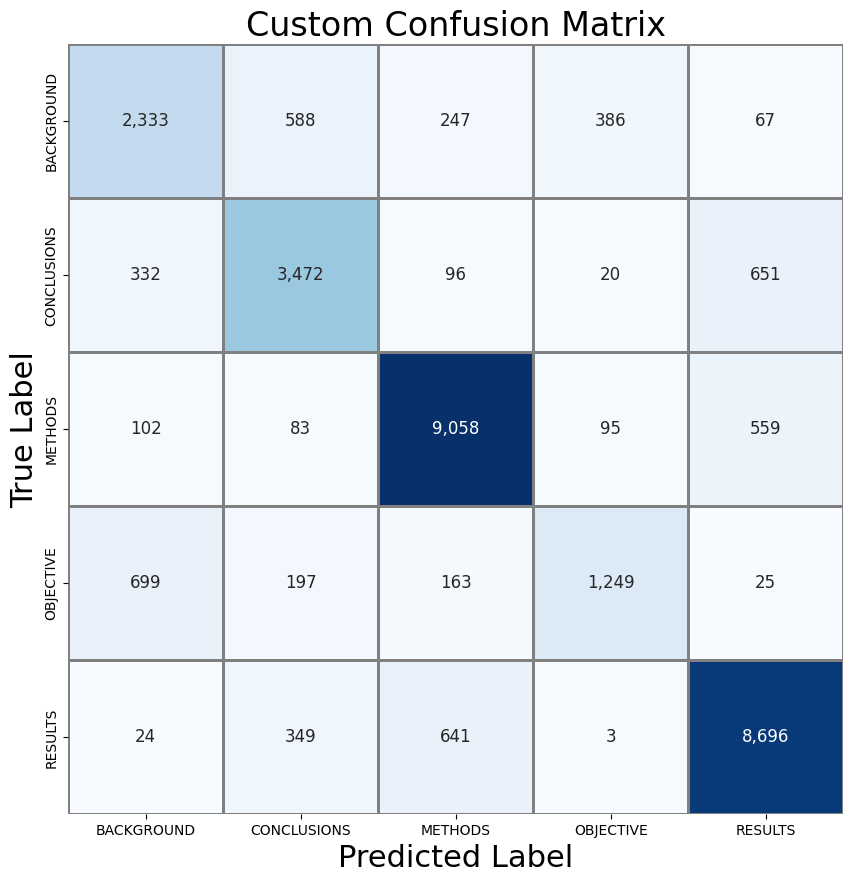

In [106]:
#Print confusion matrix
plot_custom_confusion_matrix(
    test_labels_encoded,
    model_1_preds,
    figsize=(10, 10),
    classes=list(class_names))

# **Evaluating model on test dataset**

As Model 1: Conv1D with token embedding is best performing model having highest accuracy as well as f1 score among all the models on validation as well as test set, model 1 is taken for making the prediction and comparing with the truth labels.

In [107]:
test_pred_classes = [label_encoder.classes_[pred] for pred in model_1_preds]

# **Adding below columns in test dataframe for comparing with truth label**

prediction column- contains model's prediction for a given sample.

pred_prob column- contains the model's maximum prediction probabiliy for a given sample.

correct column- indicates whether or not the model's prediction matches the sample's target label.

In [108]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(model_1_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]

In [109]:
test_df.head(50)

,abstract_text,line_number,total_lines,target,prediction,pred_prob,correct
0,This study analyzed liver function abnormaliti...,0,9,BACKGROUND,BACKGROUND,0.362066,True
1,A post hoc analysis was conducted with the use...,1,9,RESULTS,METHODS,0.906447,False
2,Liver function tests ( LFTs ) were measured at...,2,9,RESULTS,METHODS,0.900543,False
3,Survival analyses were used to assess the asso...,3,9,RESULTS,RESULTS,0.496831,True
4,The percentage of patients with abnormal LFTs ...,4,9,RESULTS,RESULTS,0.975971,True
5,When mean hemodynamic profiles were compared i...,5,9,RESULTS,RESULTS,0.999426,True
6,Multivariable analyses revealed that patients ...,6,9,RESULTS,RESULTS,0.998584,True
7,Abnormal LFTs are common in the ADHF populatio...,7,9,CONCLUSIONS,BACKGROUND,0.615470,False
8,Elevated MELD-XI scores are associated with po...,8,9,CONCLUSIONS,CONCLUSIONS,0.514713,True
9,Minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,CONCLUSIONS,0.651028,False


In [110]:
#Inspect Most 50 Inaccurate Predictions
top_50_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:50]
top_50_wrong

,abstract_text,line_number,total_lines,target,prediction,pred_prob,correct
13598,-1.5 % vs. Fish : -1.4 % vs. Fish + S : -0.7 %...,6,10,METHODS,RESULTS,0.999807,False
28736,Ankle brachial index ( ABI ) was classified as...,7,14,METHODS,RESULTS,0.999792,False
21186,Mean distraction rates were similar between gr...,8,18,METHODS,RESULTS,0.999725,False
9130,The expected CIN rate was similar for the two ...,4,11,METHODS,RESULTS,0.999712,False
28424,"However , the subgroup of subjects , which inh...",5,11,BACKGROUND,RESULTS,0.999606,False
30065,There was no significant difference in gender ...,4,13,METHODS,RESULTS,0.999508,False
12158,"In the saffron group , there was no decline in...",9,13,METHODS,RESULTS,0.999156,False
9467,Total anaerobic counts of bacteria did not dif...,6,10,CONCLUSIONS,RESULTS,0.998354,False
9468,PDT was associated with a significant decrease...,7,10,CONCLUSIONS,RESULTS,0.998349,False
19313,( 3 ) The differences in heart rate and blood ...,17,20,METHODS,RESULTS,0.998211,False
